# Contour Stochastic Gradient Langevin Dynamics 

## Preliminaries

In [1]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import log, sqrt, sin, cos, exp, pi, prod
from autograd.numpy.random import normal, uniform

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.random.seed(6)

Build a non-convex energy function

In [3]:
def mixture(x):
    energy = ((x[0]**2 + x[1]**2)/10 - (cos(1.2*pi*x[0]) + cos(1.2*pi*x[1]))) / 0.3
    regularizer = ((x[0]**2 + x[1]**2) > 7) * ((x[0]**2 + x[1]**2) - 7)
    return energy + regularizer

In [4]:
def mixture_expand(x, y): return mixture([x, y])
def function_plot(x, y): return np.exp(-mixture([x, y]))

Suppose we are only interested in the following domain, [-2.5, 2.5] X [-2.5, 2.5]. Given the following grid based on probability and energy information.

In [5]:
boundary_ = 2.5
axis_x = np.linspace(-boundary_, boundary_, 500)
axis_y = np.linspace(-boundary_, boundary_, 500)
axis_X, axis_Y = np.meshgrid(axis_x, axis_y)

energy_grid = mixture_expand(axis_X, axis_Y)
prob_grid = function_plot(axis_X, axis_Y)

Establish the upper and lower bound for the partions.

In [6]:
lower_bound, upper_bound = np.min(energy_grid) - 1, np.max(energy_grid) + 1

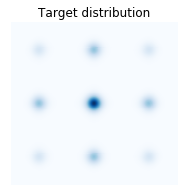

In [7]:
fig = plt.figure(figsize=(3, 3))
plt.subplot(1, 1, 1).set_title('Target distribution')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)

## Build our sampler

In [8]:
class Sampler:
    def __init__(self, f=None, dim=None, boundary=None, xinit=None, \
                 partition=None, lr=0.1, T=1.0, zeta=1, decay_lr=100., parts=100):
        self.f = f
        self.dim = dim
        self.lr = lr
        self.T = T
        self.zeta = zeta
        self.decay_lr = decay_lr
        self.parts = parts
        
        self.partition = partition # [energy lower bound, energy upper bound] -- U(x)
        self.boundary = boundary # Domain boundary of X
        
        # initialization for CSGLD
        self.x = np.array(xinit)
        self.Gcum = np.array(range(self.parts, 0, -1)) * 1.0 / sum(range(self.parts, 0, -1))
        self.div_f = (self.partition[1] - self.partition[0]) / self.parts
        self.J = self.parts - 1

    
    def in_domain(self, beta): 
        return sum(map(lambda i: beta[i] < self.boundary[0] or beta[i] > self.boundary[1], range(self.dim))) == 0

    def stochastic_grad(self, beta):  return grad(self.f)(beta) + 0.32*normal(size=self.dim)

    def stochastic_f(self, beta): return self.f(beta.tolist()) + 0.32*normal(size=1)

    # find the partition index J
    def find_idx(self, beta): 
        return(min(max(int((self.stochastic_f(beta) - self.partition[0]) / self.div_f + 1), 1), self.parts - 1))
    
    def csgld_step(self, iters):        
        self.grad_mul = 1 + self.zeta * self.T * (np.log(self.Gcum[self.J]) - np.log(self.Gcum[self.J-1])) / self.div_f
        proposal = self.x - self.lr * self.grad_mul * self.stochastic_grad(self.x) + sqrt(2. * self.lr * self.T) * normal(size=self.dim)
        
        if self.in_domain(proposal):
            self.x = proposal
        self.J = self.find_idx(self.x)
        
        step_size = min(self.decay_lr, 10./(iters**0.8+100))
        self.Gcum[:self.J] = self.Gcum[:self.J] + step_size * self.Gcum[self.J]**self.zeta * (-self.Gcum[:self.J])
        self.Gcum[self.J] = self.Gcum[self.J] + step_size * self.Gcum[self.J]**self.zeta * (1 - self.Gcum[self.J])
        self.Gcum[(self.J+1):] = self.Gcum[(self.J+1):] + step_size * self.Gcum[self.J]**self.zeta * (-self.Gcum[(self.J+1):])

Call our sampler

In [9]:
zeta = 0.75
sampler = Sampler(f=mixture, dim=2, boundary=[-boundary_, boundary_], xinit=[2.,2.], \
                  partition=[lower_bound, upper_bound], lr=1e-3, T=1, zeta=zeta, decay_lr=3e-3, parts=100)

## Simulate from a flat density and record the importance weights

In [10]:
warm_up = 5000
csgld_x = np.array([sampler.x])
importance_weights = [0.,]

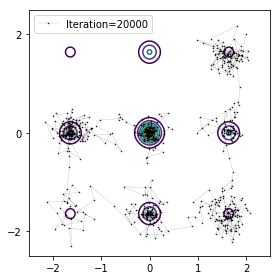

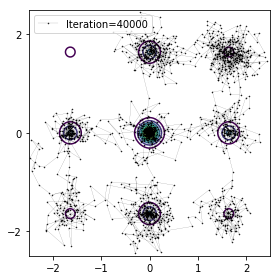

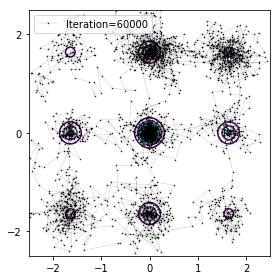

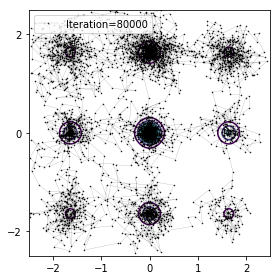

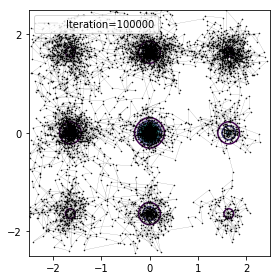

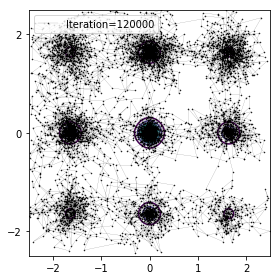

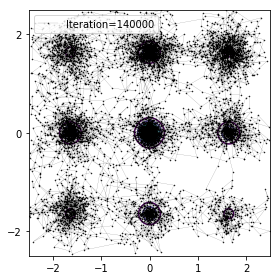

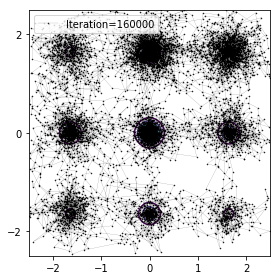

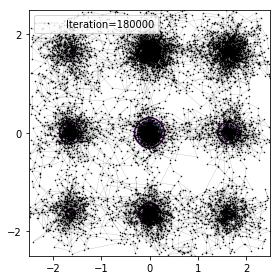

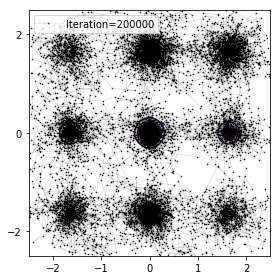

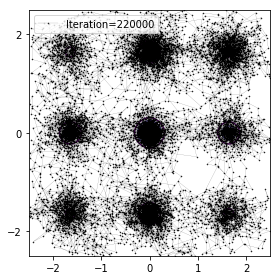

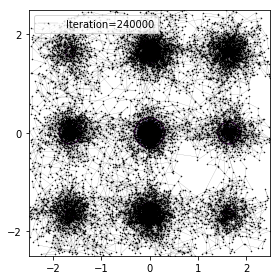

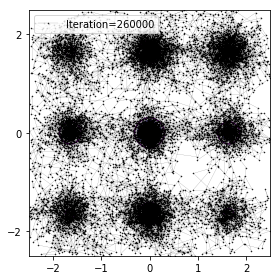

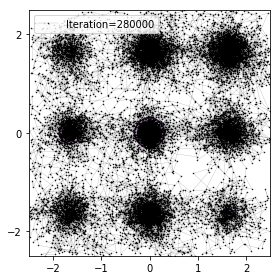

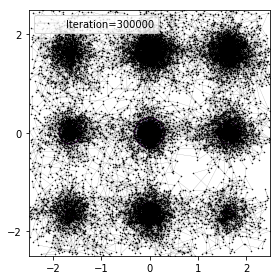

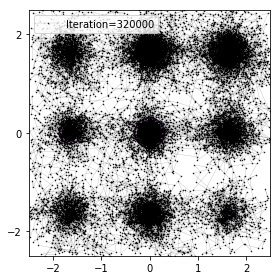

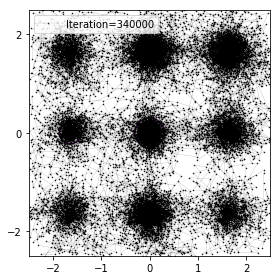

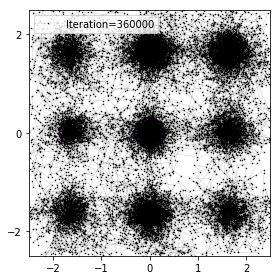

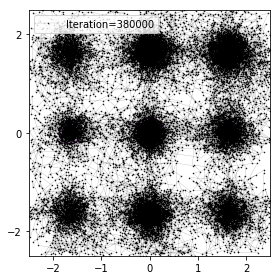

In [11]:
for iters in range(int(4e5)):
    sampler.csgld_step(iters)
    if iters > warm_up:
        if iters % 20 == 0:
            csgld_x = np.vstack((csgld_x, sampler.x))
            importance_weights.append(sampler.Gcum[sampler.J]**zeta)
        if iters % 20000 == 0:
            fig = plt.figure(figsize=(4, 4))
            plt.contour(axis_X, axis_Y, prob_grid)
            plt.yticks([-4, -2, 0, 2, 4]) 
            plt.plot(csgld_x[:,0], csgld_x[:,1], linewidth=0.1, marker='.', markersize=1, color='k', label="Iteration="+str(iters)) 
            plt.legend(loc="upper left", prop={'size': 10})
            plt.xlim([-boundary_, boundary_])
            plt.ylim([-boundary_, boundary_])
            plt.tight_layout()
            plt.show()

# Resampling via importance weights

Note that the flat density is not what we want. To recover the original density, we need to reweight the samples according to the importance weights.

In [12]:
scaled_importance_weights = importance_weights / np.mean(importance_weights)

resample_x = np.empty((0,2))
for i in range(len(csgld_x)):
    while scaled_importance_weights[i] > 1:
        tag = np.random.binomial(1, p=min(1, scaled_importance_weights[i]))
        scaled_importance_weights[i] -= 1
        if tag == 1:
            resample_x = np.vstack((resample_x, csgld_x[i,]))

(-2.5, 2.5)

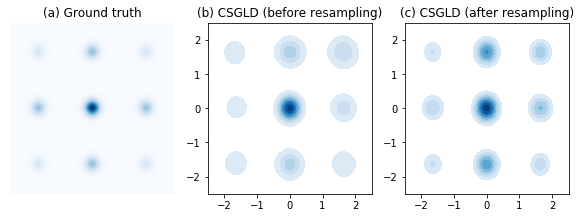

In [13]:
fig = plt.figure(figsize=(10, 3.15))
plt.subplot(1, 3, 1).set_title('(a) Ground truth')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)

warm_sample = 50
split_ = 1
plt.subplot(1, 3, 2).set_title('(b) CSGLD (before resampling)')
ax = sns.kdeplot(csgld_x[:,0][::split_][warm_sample:], csgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, shade_lowest=False)
ax.set_xlim(-boundary_, boundary_)
ax.set_ylim(-boundary_, boundary_)

plt.subplot(1, 3, 3).set_title('(c) CSGLD (after resampling)')
ax = sns.kdeplot(resample_x[:,0][::split_][warm_sample:], resample_x[:,1][::split_][warm_sample:], cmap="Blues", shade=True, shade_lowest=False)
ax.set_xlim(-boundary_, boundary_)
ax.set_ylim(-boundary_, boundary_)